In [0]:
# !unzip "MonuSeg.zip"

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

%tensorflow_version 1.x

import tensorflow as tf
from keras import layers
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Layer, InputSpec, Conv2D, DepthwiseConv2D, UpSampling2D, ZeroPadding2D, Lambda, AveragePooling2D, Activation, Concatenate, Add, Reshape
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import relu
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.engine.topology import get_source_inputs
from keras.utils import conv_utils
from keras import backend as K


In [0]:

# Set some parameters
# !pip freeze
im_width = 128
im_height = 128
border = 5

In [20]:
 ids = next(os.walk("MonuSeg/Training/TissueImages"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  30


In [0]:
X = np.zeros((len(ids*64), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids*64), im_height, im_width, 1), dtype=np.float32)

In [0]:
def crop_img(oimg, n, isImg):
  i=-7
  for z in range(1, 9):
    i+=7
    for x in range(1, 9):
      ind = (n+(x-1)+(z-1)+i)
      img = oimg[(x*128)-128: x*128, (z*128)-128: z*128]
      if(isImg):
        X[ind] = img/255.0
      else: 
        y[ind] = img/255.0

#### Load the images and masks into arrays

In [23]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("MonuSeg/Training/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (1024, 1024, 1), mode = 'constant', preserve_range = True)
    crop_img(x_img, n*64, True)
    # Load masks
    iid = id_.replace('.png', '')
    mask = img_to_array(load_img("MonuSeg/Training/GroundTruth/"+iid+"_bin_mask.png", grayscale=True))
    mask = resize(mask, (1024, 1024, 1), mode = 'constant', preserve_range = True)
    crop_img(mask, n*64, False)
  
    # # Save images
    # X[n] = x_img/255.0
    # y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Mask')

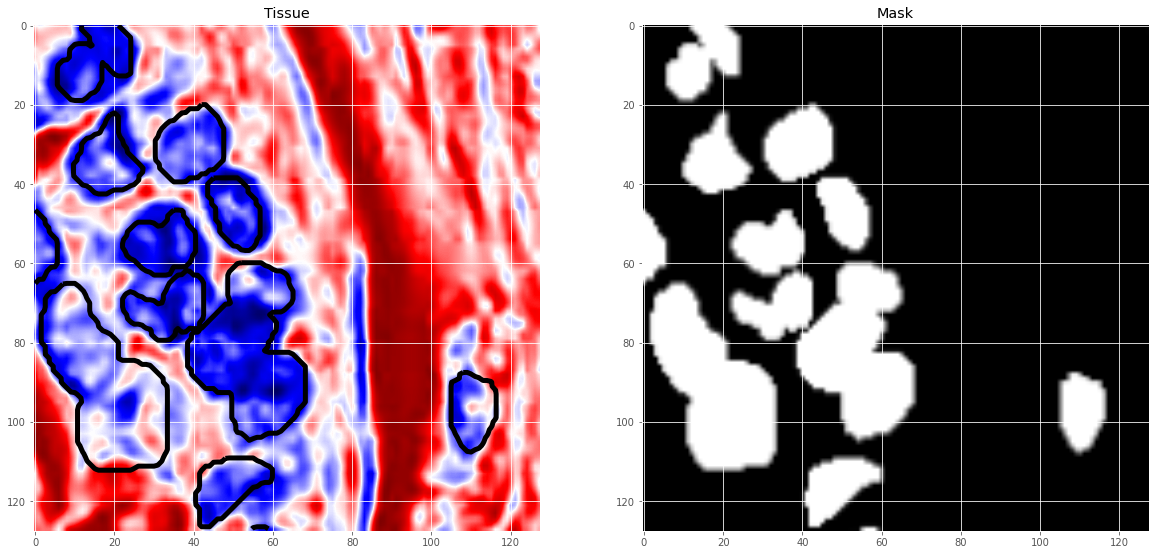

In [25]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Tissue')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True, secondLayer=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if secondLayer:
      # second layer
      x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
      if batchnorm:
        x = BatchNormalization()(x)
      x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
def SegNet(input_img, classes=1):
    # Encoder
    x = conv2d_block(input_img, 64, kernel_size = 3)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = conv2d_block(x, 128, kernel_size = 3, secondLayer=False)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = conv2d_block(x, 256, kernel_size = 3, secondLayer=False)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = conv2d_block(x, 512, kernel_size = 3)
    
    # Decoder
    x = conv2d_block(x, 512, kernel_size = 3)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = conv2d_block(x, 256, kernel_size = 3, secondLayer=False)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = conv2d_block(x, 128, kernel_size = 3, secondLayer=False)
    
    x = UpSampling2D(size=(2, 2))(x)
    x = conv2d_block(x, 64, kernel_size = 3)

    x = Conv2D(1, (1, 1), activation='sigmoid')(x)
    model = Model(inputs=[input_img],  outputs=[x])
    return model

In [0]:
def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand
        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        #x = Lambda(lambda x: relu(x, max_value=6.))(x)
        x = Lambda(lambda x: relu(x, max_value=6.), name=prefix + 'expand_relu')(x)
        #x = Activation(relu(x, max_value=6.), name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)
    #x = Activation(relu(x, max_value=6.), name=prefix + 'depthwise_relu')(x)
    x = Lambda(lambda x: relu(x, max_value=6.), name=prefix + 'depthwise_relu')(x)

    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(input_tensor=None,
              input_shape=(im_width, im_height, 3), classes=1, backbone='xception',
              OS=16, alpha=1.):
    
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC. This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    data format `(width, height, channels)`.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc)
            or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images
        classes: number of desired classes. If classes != 21,
            last layer is initialized randomly
        backbone: backbone to use. one of {' ','mobilenetv2'}
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """
    
    if K.backend() != 'tensorflow':
        raise RuntimeError('The Deeplabv3+ model is only available with '
                           'the TensorFlow backend.')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    
    
    
    batches_input = Lambda(lambda x: x/127.5 - 1)(img_input)

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)
        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(batches_input)
            
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation('relu')(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation('relu')(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(batches_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        
        x = Lambda(lambda x: relu(x, max_value=6.))(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    #out_shape = int(np.ceil(input_shape[0] / OS))
    b4 = AveragePooling2D(pool_size=(int(np.ceil(input_shape[0] / OS)), int(np.ceil(input_shape[1] / OS))))(x)
        
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    
    b4 = Lambda(lambda x: tf.image.resize_bilinear(x,size=(int(np.ceil(input_shape[0]/OS)), int(np.ceil(input_shape[1]/OS)))))(b4)

    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])
        
    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block

        x = Lambda(lambda x: tf.image.resize_bilinear(x,size=(int(np.ceil(input_shape[0]/4)), int(np.ceil(input_shape[1]/4)))))(x)
        
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation('relu')(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if classes == 21:
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'
    
    
    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    x = Lambda(lambda x: tf.image.resize_bilinear(x,size=(input_shape[0],input_shape[1])))(x)
    x = Activation('softmax')(x)
    
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='deeplabv3p')
    return model

In [0]:
# Metrics and Losses
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    res = dice_coef(y_true, y_pred)
    return -res

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [0]:
input_img = Input((im_height, im_width, 1), name='img')
dlv3 = Deeplabv3(input_img)
dlv3.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", get_f1, iou_coef])

In [32]:
input_img = Input((im_height, im_width, 1), name='img')
uNet = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
uNet.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=["accuracy", get_f1, iou_coef])

In [33]:
input_img = Input((im_height, im_width, 1), name='img')
segNet = SegNet(input_img)
segNet.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=["accuracy", get_f1, iou_coef])

In [34]:
dlv3.summary()

Model: "deeplabv3p"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128, 128, 1)  0           img[0][0]                        
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 64, 64, 32)   288         lambda_5[0][0]                   
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 64, 64, 32)   128         entry_flow_conv1_1[0][0]         
_________________________________________________________________________________________

In [35]:
uNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_166 (Activation)     (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [36]:
segNet.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_20 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_184 (Activation)  (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_21 (Batc (None, 64, 64, 128)       512 

In [0]:

def getCallbacks(name):
    return [EarlyStopping(patience=5, verbose=1),
      ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
      ModelCheckpoint(name, verbose=1, save_best_only=True, save_weights_only=True)]


In [0]:
resultsdlNet = dlv3.fit(X_train, y_train, batch_size=64, epochs=10, callbacks=getCallbacks('model-deepLab.h5'),\
                    validation_data=(X_valid, y_valid))

In [39]:
resultsuNet = uNet.fit(X_train, y_train, batch_size=64, epochs=10, callbacks=getCallbacks('model-uNet.h5'),\
                    validation_data=(X_valid, y_valid))



Train on 1728 samples, validate on 192 samples
Epoch 1/10
1728/1728 [==============================] - 163s 94ms/step - loss: -0.5250 - acc: 0.6724 - get_f1: 0.5831 - iou_coef: 0.3433 - val_loss: -0.6286 - val_acc: 0.7513 - val_get_f1: 0.6632 - val_iou_coef: 0.4286

Epoch 00001: val_loss improved from inf to -0.62863, saving model to model-uNet.h5
Epoch 2/10
1728/1728 [==============================] - 146s 85ms/step - loss: -0.6297 - acc: 0.7797 - get_f1: 0.6964 - iou_coef: 0.4411 - val_loss: -0.6284 - val_acc: 0.7785 - val_get_f1: 0.6969 - val_iou_coef: 0.4347

Epoch 00002: val_loss did not improve from -0.62863
Epoch 3/10
1728/1728 [==============================] - 146s 85ms/step - loss: -0.6627 - acc: 0.7949 - get_f1: 0.7164 - iou_coef: 0.4753 - val_loss: -0.6461 - val_acc: 0.8021 - val_get_f1: 0.7135 - val_iou_coef: 0.4490

Epoch 00003: val_loss improved from -0.62863 to -0.64610, saving model to model-uNet.h5
Epoch 4/10
1728/1728 [==============================] - 146s 84ms/st

In [0]:
resultssegNet = segNet.fit(X_train, y_train, batch_size=64, epochs=10, callbacks=getCallbacks('model-segNet.h5'),\
                    validation_data=(X_valid, y_valid))

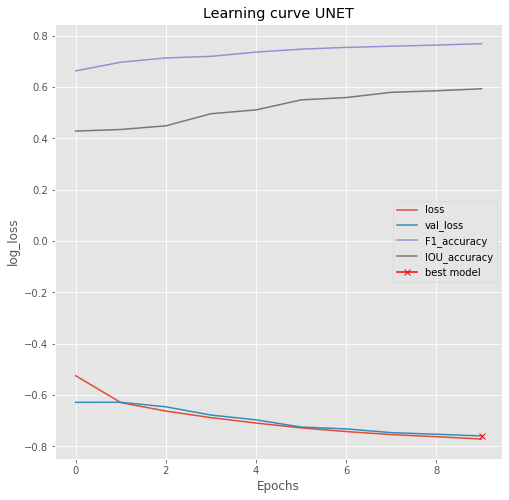

In [41]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve UNET")
plt.plot(resultsuNet.history["loss"], label="loss")
plt.plot(resultsuNet.history["val_loss"], label="val_loss")
plt.plot(resultsuNet.history["val_get_f1"], label="F1_accuracy")
plt.plot(resultsuNet.history["val_iou_coef"], label="IOU_accuracy")
plt.plot( np.argmin(resultsuNet.history["val_loss"]), np.min(resultsuNet.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve SegNet")
plt.plot(resultssegNet.history["loss"], label="loss")
plt.plot(resultssegNet.history["val_loss"], label="val_loss")
plt.plot(resultssegNet.history["val_get_f1"], label="F1_accuracy")
plt.plot(resultssegNet.history["val_iou_coef"], label="IOU_accuracy")
plt.plot( np.argmin(resultssegNet.history["val_loss"]), np.min(resultssegNet.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve DeepLavV3")
plt.plot(resultsdlNet.history["loss"], label="loss")
plt.plot(resultsdlNet.history["val_loss"], label="val_loss")
plt.plot(resultsdlNet.history["val_get_f1"], label="F1_accuracy")
plt.plot(resultsuNet.history["val_iou_coef"], label="IOU_accuracy")
plt.plot( np.argmin(resultsdlNet.history["val_loss"]), np.min(resultsdlNet.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [0]:
# load the best model
uNet.load_weights('model-uNet.h5')

In [46]:
# Evaluate on validation set (this must be equals to the best log_loss)
uNet.evaluate(X_valid, y_valid, verbose=1)

192/192 [==============================] - 4s 23ms/step


[-0.7591817577679952,
 0.8322537740071615,
 0.7687367101510366,
 0.5932734707991282]

In [0]:
segNet.load_weights('model-segNet.h5')

In [0]:
segNet.evaluate(X_valid, y_valid, verbose=1)

In [0]:
dlv3.load_weights('model-deepLab.h5')

In [0]:
dlv3.evaluate(X_valid, y_valid, verbose=1)

In [47]:
# Predict on train, val and test
preds_train = uNet.predict(X_train, verbose=1)
preds_val = uNet.predict(X_valid, verbose=1)

192/192 [==============================] - 4s 22ms/step


In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='Accent')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('base')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('cell')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('cell Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('cell Predicted binary');

### Predictions on training set

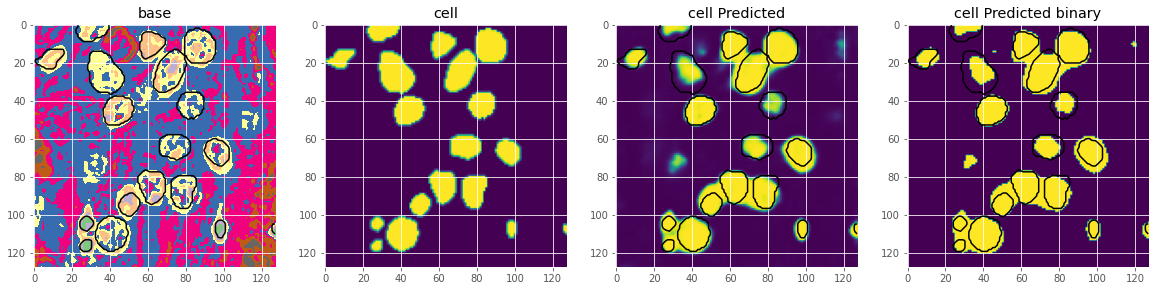

In [50]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

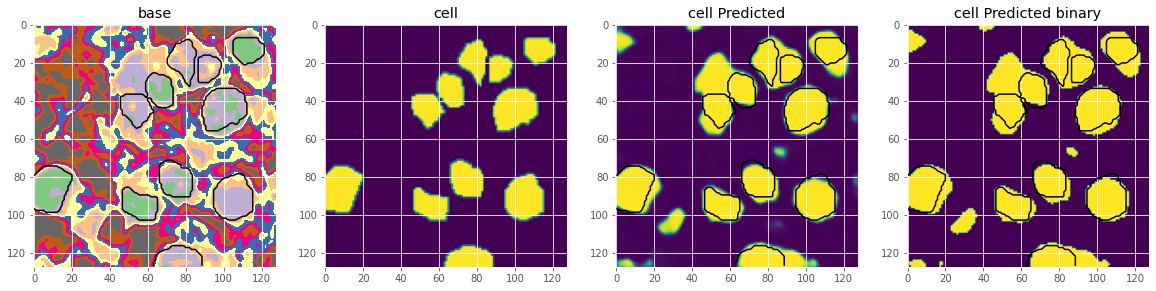

In [51]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

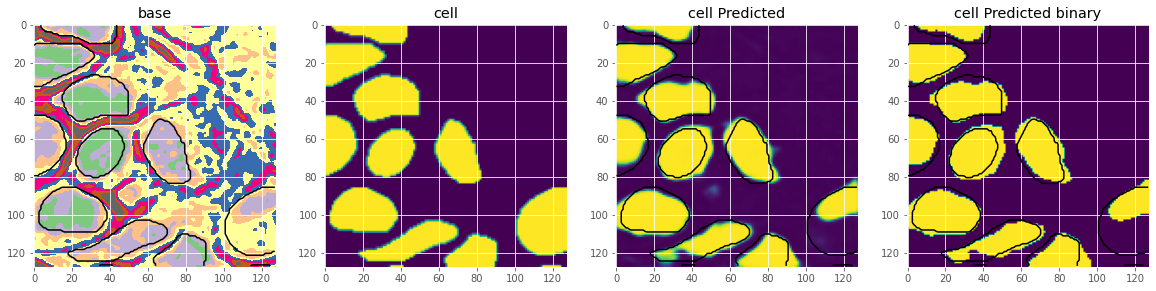

In [52]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

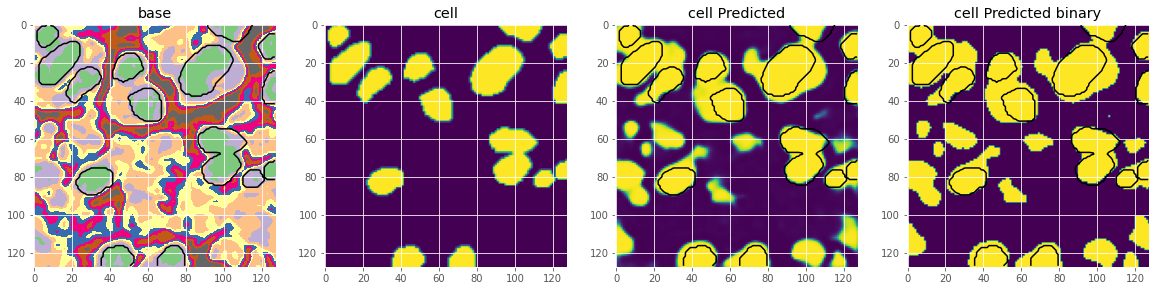

In [53]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

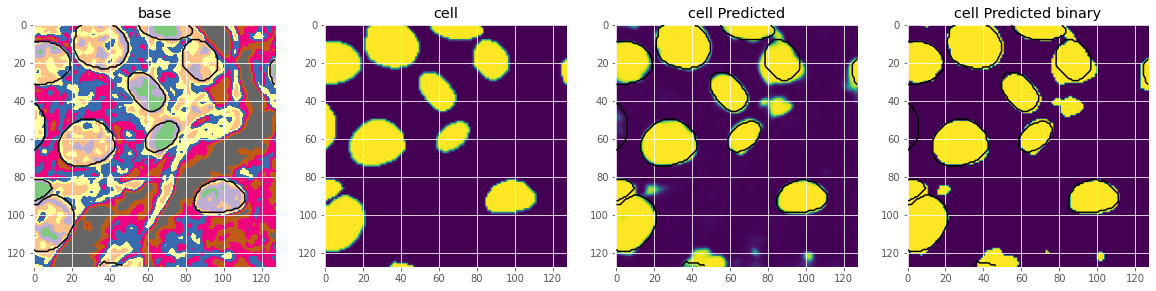

In [54]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

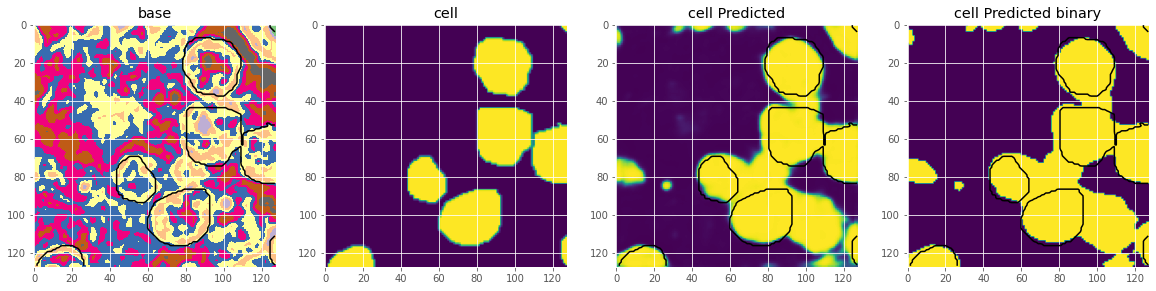

In [55]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

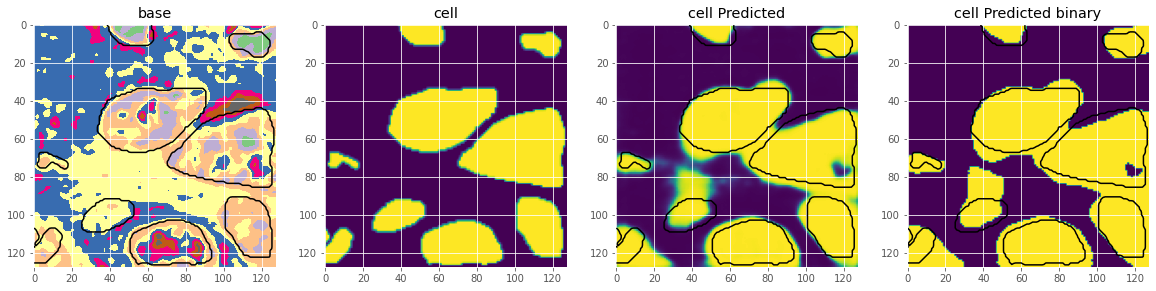

In [56]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

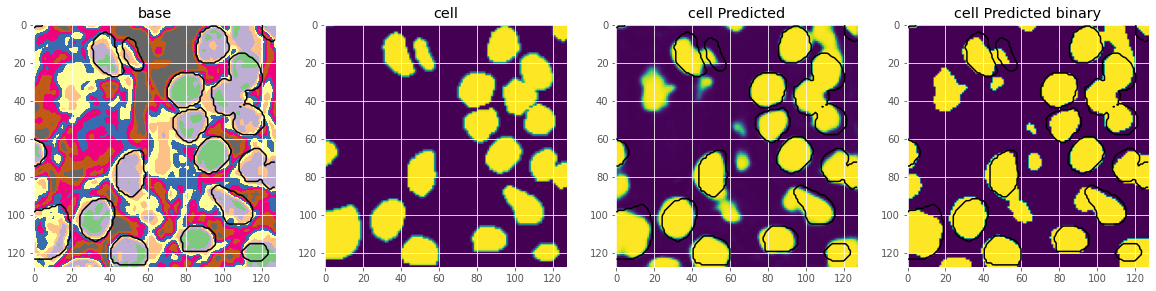

In [57]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

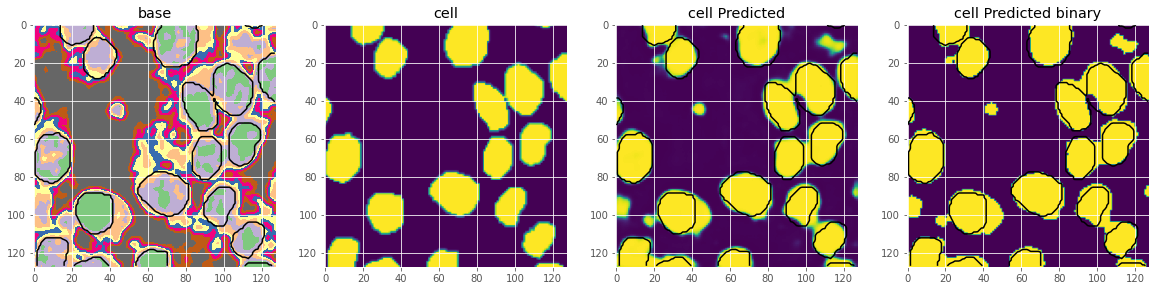

In [58]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

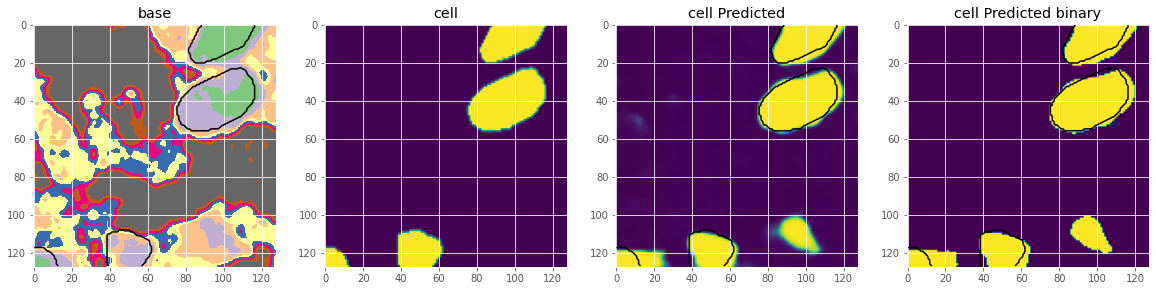

In [59]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

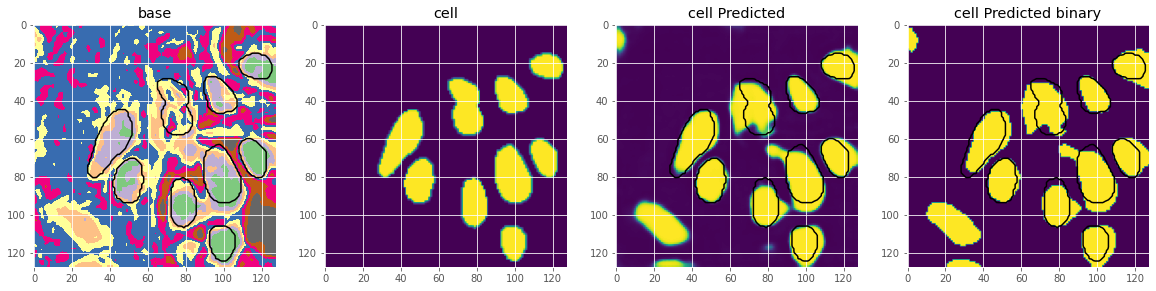

In [60]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

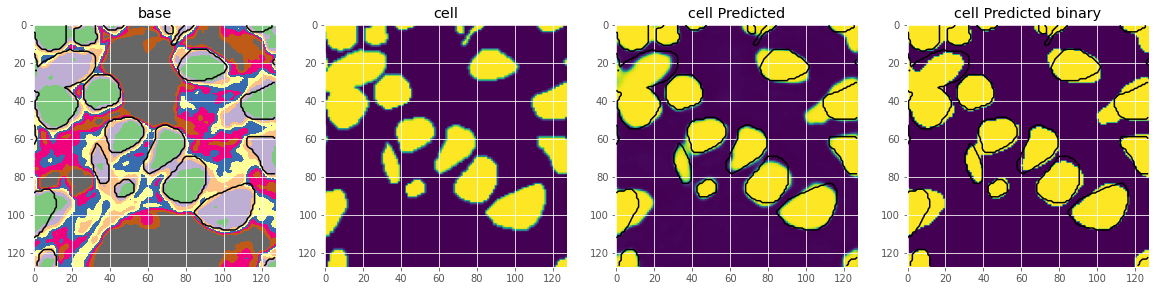

In [61]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

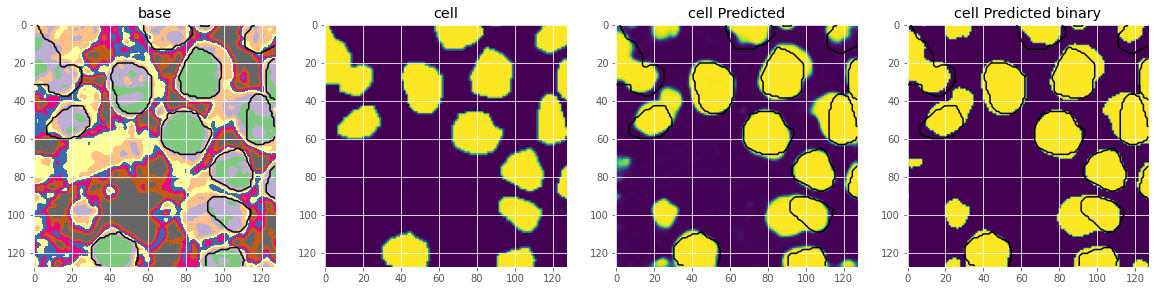

In [62]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

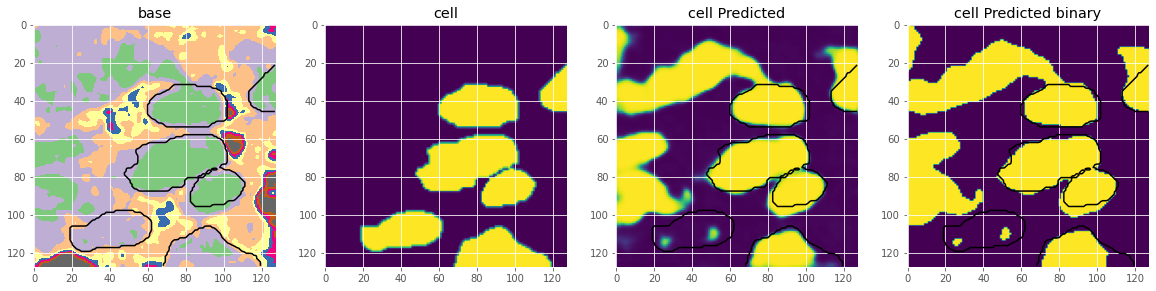

In [63]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

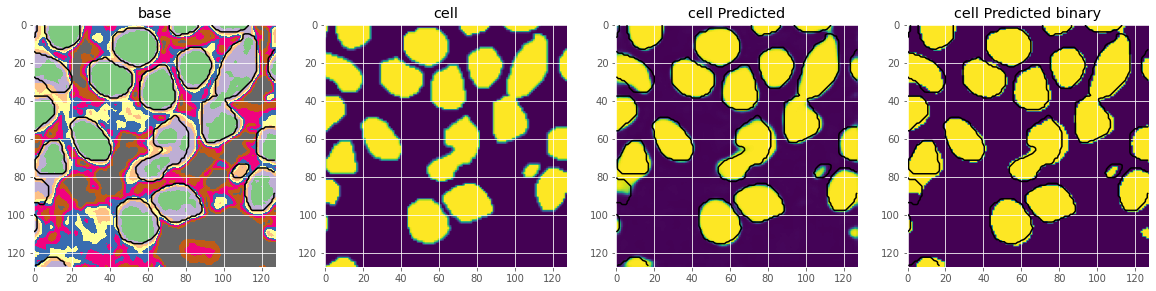

In [64]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

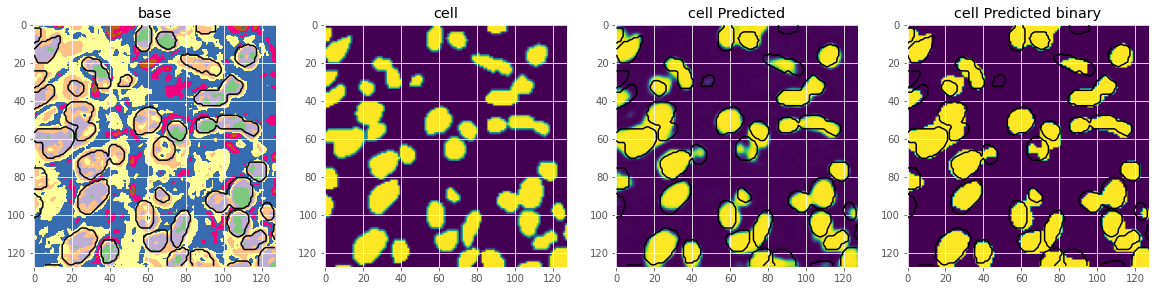

In [65]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

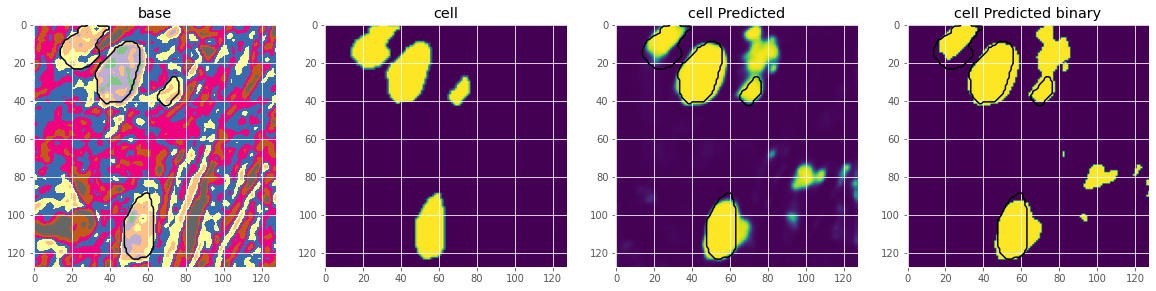

In [66]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

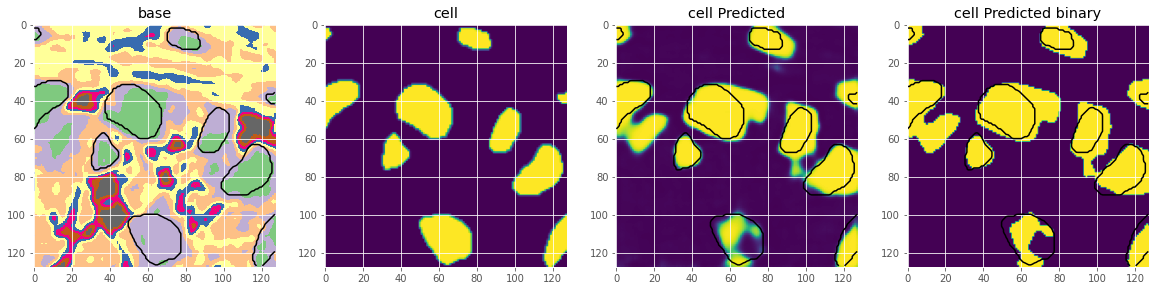

In [67]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

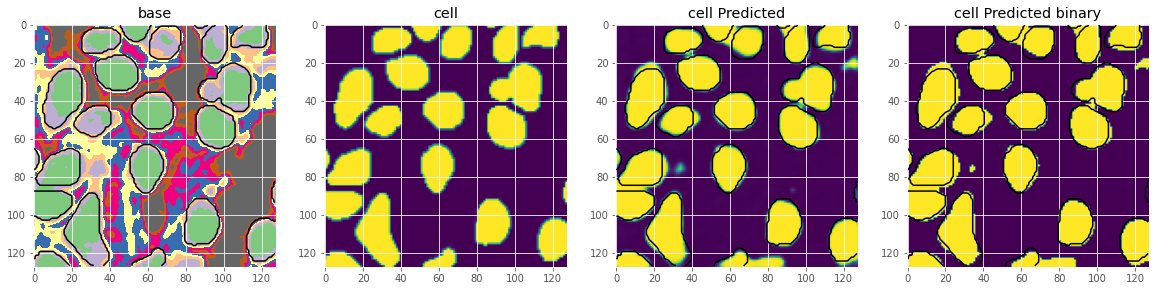

In [68]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

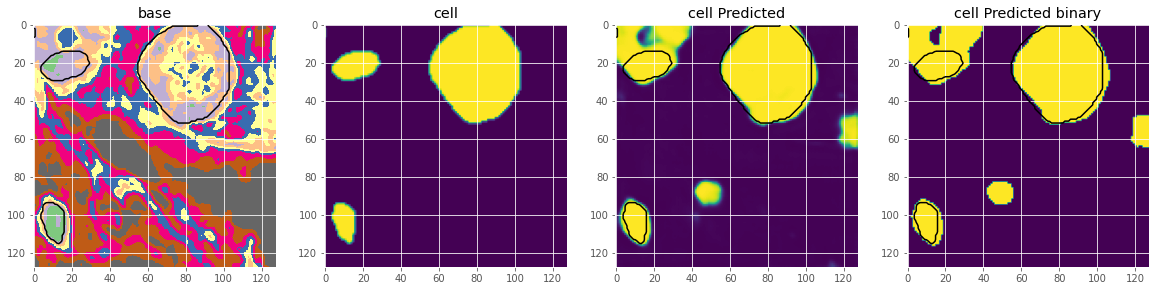

In [69]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

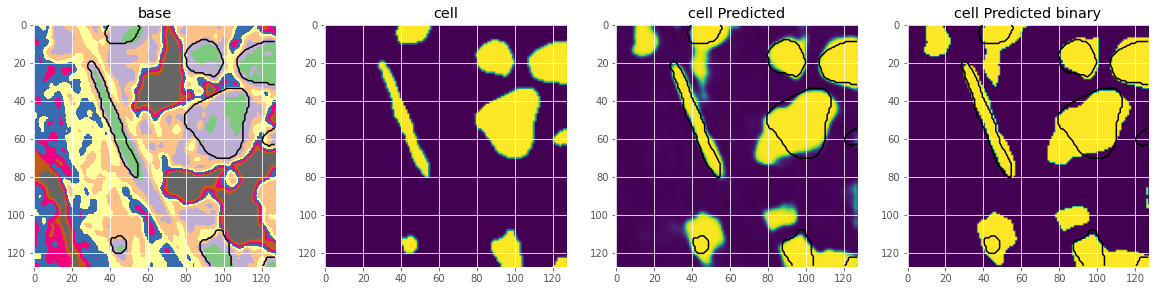

In [70]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

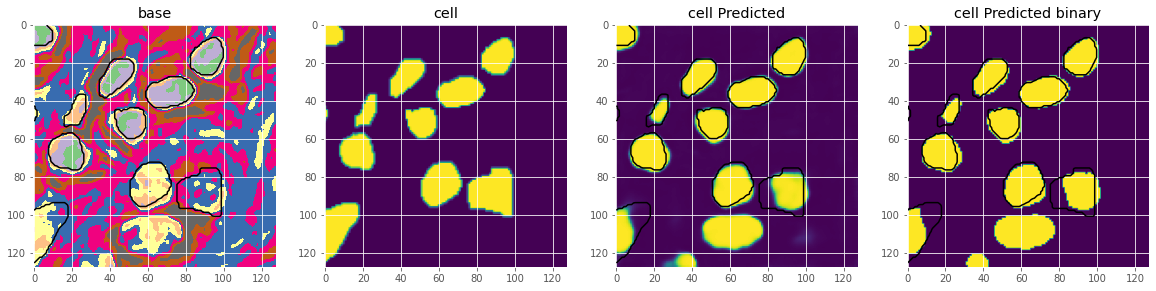

In [71]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

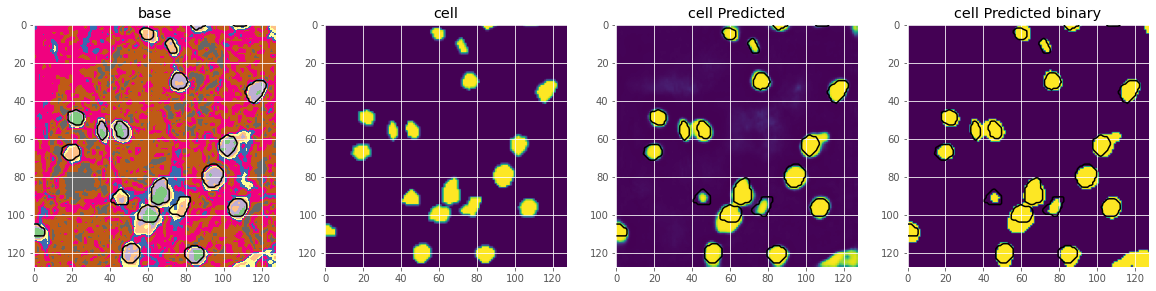

In [72]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

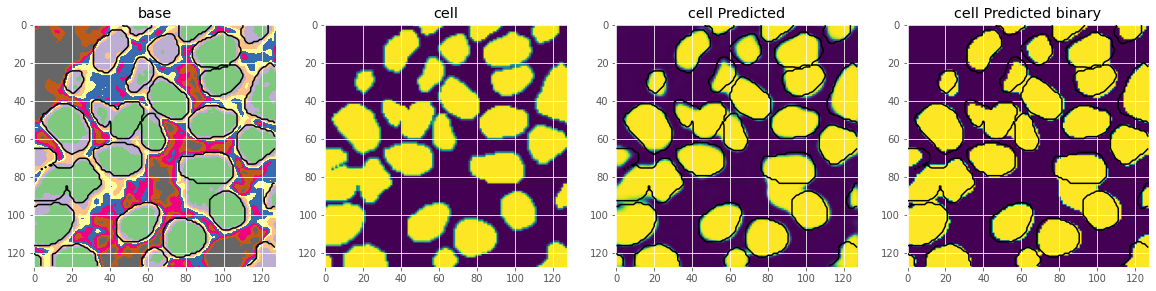

In [73]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

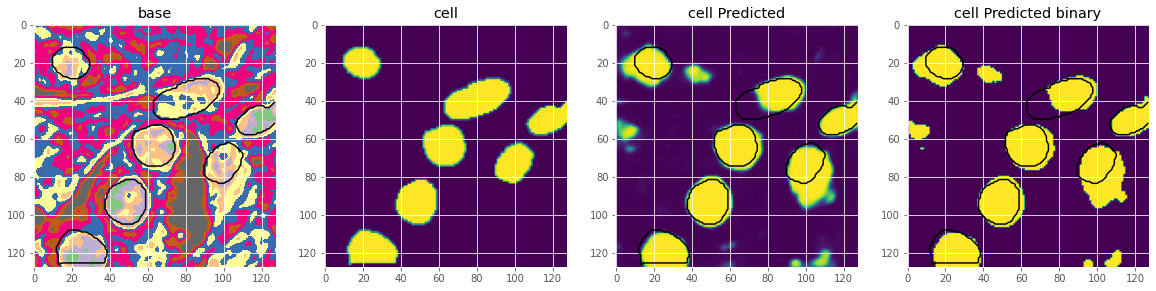

In [74]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

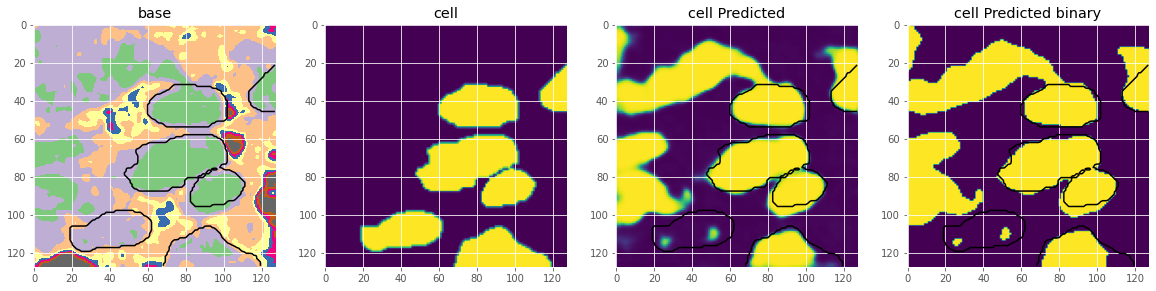

In [75]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

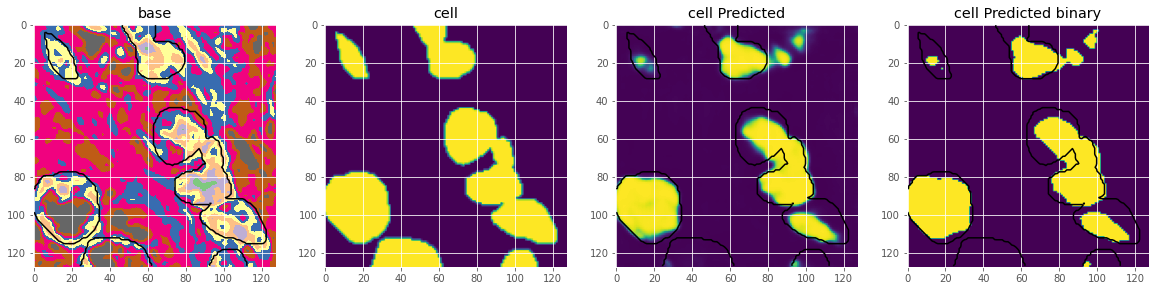

In [76]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

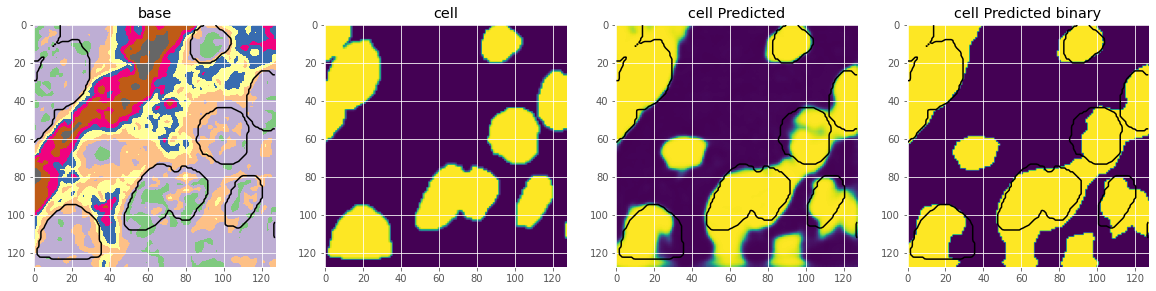

In [77]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)